In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_10000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS', 'SEED', 'SOURCE', 'FILE', 'EXPOSURE'])
DS dataset size: 5000


In [2]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(4000, 200, 200) (4000, 2)
Train dataset: 4000, (4000, 200, 200, 1)
Train labels: 4000, (4000, 2)

Test dataset: 1000, (1000, 200, 200, 1)
Test labels: 1000, (1000, 2)


In [3]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
19196,crab_04197,4197,0,100,100,211.304838,51.026275,212.041713,50.183405,0.963909,North_z60_S_5h_LST,2.5,6.448213


# Load model and weights

In [4]:
import tensorflow as tf

savename = 'regressor_200x200_filter2_90kp_4convs' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

2024-02-18 14:54:53.114360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 14:54:53.295696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-18 14:54:53.295729: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-18 14:54:54.100363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                                                        

In [5]:
%time
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 17.2 µs
32/32 [==============================] - 1s 21ms/step


(array([113.8404 , 125.98084], dtype=float32),
 array([117.55292719, 132.8188508 ]))

In [6]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
point_ref, pixelsize

x, y = predictions[idx][0], predictions[idx][1]
xl, yl = test_labels[idx][0], test_labels[idx][1]

sky = w.pixel_to_world(x, y)
f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg}) TRUE: ({row['source_ra'].values[0]}, {row['source_dec'].values[0]})"

'PREDICTION: (211.45502120324426, 50.85584463496671) TRUE: (211.3048380456797, 51.02627451499168)'

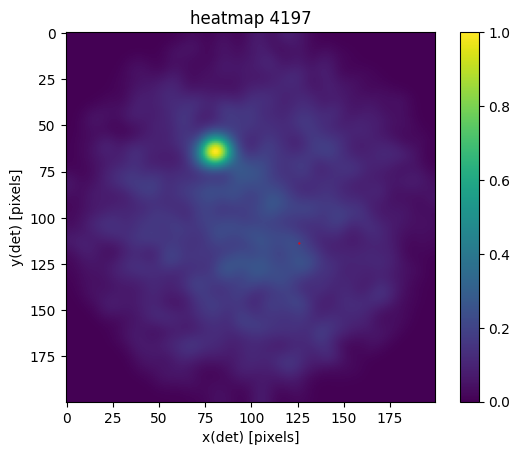

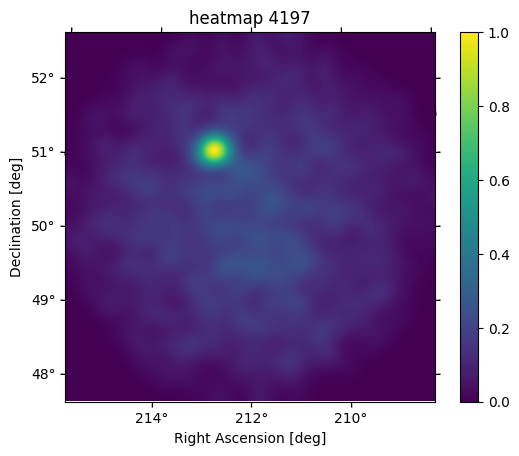

In [7]:
# plot map and prediction  
plot_heatmap(np.flipud(test_data[idx]), title=f'heatmap {seed}', show=True, 
             add_markers={'SRC': {'x': x, 'y': y, 'r': 0.2}})

# plot map and prediction wcs=w, 
plot_heatmap_wcs(test_data[idx], wcs=w, title=f'heatmap {seed}', show=True, 
                 add_markers={'SRC': {'x': sky.ra.deg, 'y': sky.dec.deg, 'r': 0.2}})

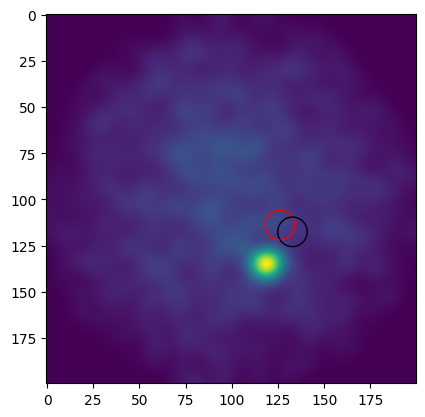

In [8]:
yx = y, x
yxl = yl * binning, xl * binning
radius_pix = 0.2/0.025

ax = plt.subplot()
ax.imshow(np.fliplr(test_data[idx]), vmin=0, vmax=1)
ax.add_patch(plt.Circle(yx, radius=radius_pix, edgecolor='r', facecolor='none'))
ax.add_patch(plt.Circle(yxl, radius=radius_pix, edgecolor='k', facecolor='none'))

plt.show()

# Plot loss

In [9]:
loss = model.evaluate(test_data, test_labels, verbose=2)

32/32 - 1s - loss: 0.0363 - accuracy: 0.9360 - 740ms/epoch - 23ms/step


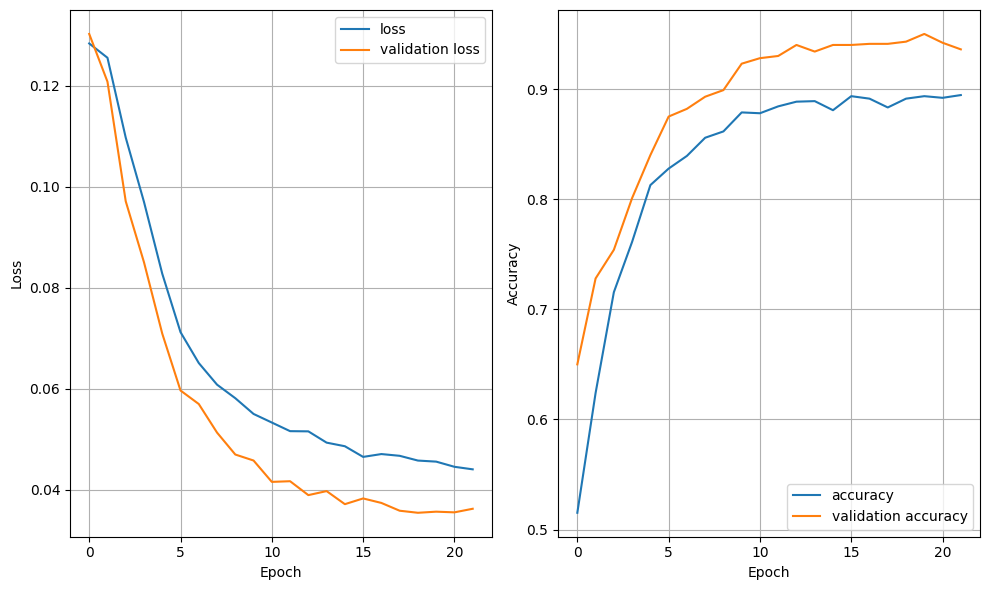

In [10]:
import matplotlib.pyplot as plt

history = np.load(f'/data01/homes/dipiano/astroAI/astroai/models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].plot(history['loss'], label='loss')
ax[0].plot(history['val_loss'], label = 'validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
#ax.set_ylim([0.2,0.65])
ax[0].grid()
ax[0].legend(loc=0)

ax[1].plot(history['accuracy'], label='accuracy')
ax[1].plot(history['val_accuracy'], label = 'validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
#ax.set_ylim([0.2,0.65])
ax[1].grid()
ax[1].legend(loc=0)

plt.tight_layout()
plt.show()

# Get separation error

In [11]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (211.3048380456797, 51.02627451499168)

PREDICTION: (211.45502120324426, 50.85584463496671)

ERROR: 0.19494043414697945


# Get DS separation error

In [12]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

[0.07098678953415478,
 0.8563536700828491,
 0.838040697294101,
 0.1787836509449776,
 0.3436771769468533,
 0.9099176117909776,
 0.01328528020200673,
 0.31165528781307095,
 0.33197047210713776,
 0.07100389916642018,
 0.2565761649849661,
 0.3529319215063153,
 0.18337227984461385,
 0.057910749596988824,
 0.2107000022988716,
 0.0861612137469361,
 0.15153793361298318,
 0.425916298157528,
 0.2012546937073083,
 0.24141752178924172,
 0.15980169234585687,
 0.31501788106881273,
 0.11537177078734864,
 0.2272096006088682,
 0.14846648218929104,
 0.09583492310323041,
 0.05145315508162014,
 0.1714069016705547,
 0.04277231320281663,
 0.45998775479222936,
 0.05312079545597771,
 0.19379597082754668,
 0.2488816010534439,
 0.1259680039458853,
 0.18722875767195565,
 0.02218994877946965,
 0.03869156625167216,
 0.18991884779029594,
 0.365395237739448,
 0.29952038983393486,
 0.13949542520041036,
 0.22311452539777993,
 0.06819453916806913,
 0.13504405551099033,
 0.07838383780781562,
 0.05673303193567085,
 0.090

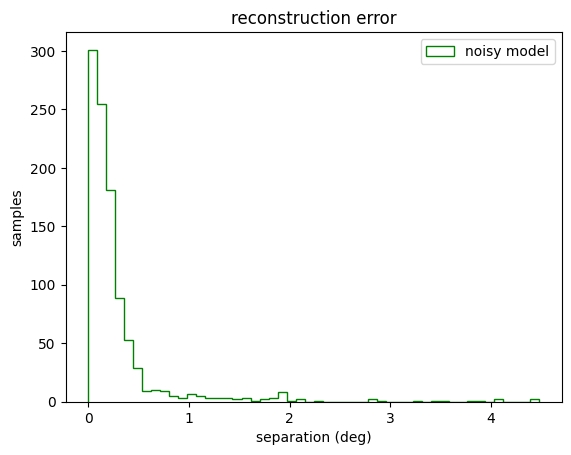

In [13]:
ax = plt.subplot()

# cumulative counts hist
data = err_noisy
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()

# Compare with cleaned model

In [14]:
# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regressor_100s_5sgm_5000sz_200x200_YESnorm_NOstretch_CLEAN.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]

# split data
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, 
                                                                            binning=binning)
# load model
savename = 'regressor_200x200_filter2_90kp_4convs_CLEAN' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

# predictions
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

(4000, 200, 200, 1) (4000, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                          

(array([115.04623, 131.17035], dtype=float32),
 array([117.55292719, 132.8188508 ]))

In [15]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_clean = [e.degree for e in err]
len(err_clean)

[0.09558388687968981,
 1.3632748350972062,
 0.19652586975561848,
 0.07046402070199075,
 0.27854068775347823,
 0.8930393191446594,
 0.029819417109118878,
 0.3893390066027088,
 0.2891138825143381,
 0.10539365365861432,
 0.1568649954444008,
 0.32589151801710675,
 0.0828222266667714,
 0.0807785418847306,
 0.3587356301715862,
 0.3590639795462568,
 0.06213337605074335,
 0.18509867016070933,
 0.1537442733051501,
 0.06014357102501476,
 0.18046063674477195,
 0.24787837760642634,
 0.07622088143250927,
 0.028168712452690887,
 0.15359036911094306,
 0.10487096500411248,
 0.03792540151681506,
 0.20643642037739854,
 0.19173110499525375,
 0.4718927686443845,
 0.1754375809874772,
 0.3773929335325942,
 0.12415926643242672,
 0.03843087162991904,
 0.1022906076815649,
 0.014028129857910973,
 0.04172309807525247,
 0.3319973124301545,
 0.19248876784238828,
 0.5757782859478949,
 0.21848247542896213,
 0.09295038582786919,
 0.021507318248966657,
 0.3762694080051984,
 0.3696960421903046,
 0.05539331174838908,
 0

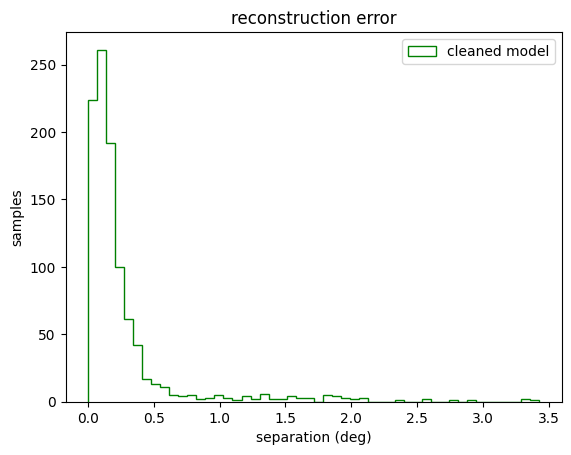

In [16]:
ax = plt.subplot()

# cumulative counts hist
data = err_clean
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color='g', label=['cleaned model'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()

# Comparison hist

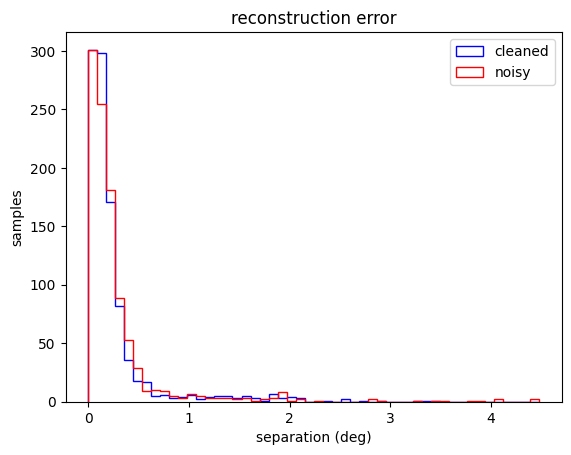

In [17]:
data = (err_noisy, err_clean)

ax = plt.subplot()
colors = ['red', 'blue'] 

# cumulative counts hist
ax.set_title('reconstruction error')
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['noisy', 'cleaned'])
ax.set_ylabel('samples')
ax.set_xlabel('separation (deg)')
ax.legend()